# NORTA
This is a homework implementation of the well-knwon algorithm to generation d-dimensional random vector with correlations. The NORTA or NORmal To Anything Algorithm can create this random vectors by giving just the d-marginal of each dimension. But it degenerates as the dimension grows.

The original paper can be found [here](https://pdfs.semanticscholar.org/8a45/34b1031d611876e2ee047ff5d2dc3757397c.pdf).

In [221]:
import numpy as np
from scipy.stats import norm, beta, expon, uniform, gamma, erlang, poisson

class Norta:
    """
    This class contains the NORmal To Anything (NORTA) algorithm to produce vector with correlations in the dimensions.
    
    Init:
    matrix M (mxn), wich has n-dimensions and m-observations per dimension.
    *args Marginal functions from which the dimension come from.
    If needed **kwargs will contain the parameter (by name) of the Marginal functions
    
    Methods:
    generate: Once initialize the parameters and functions, given the n-observation to generate, the method
    creates a matrix of mxn elementes, with identical Marginal distributions as the original described and with 
    the same correlation.
    """
    def __init__(self):
        self.contenedor = []
    
    def set_marginal(self, *args, **kwargs):
        if args[0] == 'normal':
            if ('mu' in kwargs) and ('sigma' in kwargs):
                self.contenedor.append({'function':norm,'mu':kwargs.get('mu'),'sigma':kwargs.get('sigma')})
                print("Normal function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a normal function as arg and kwargs: set_marginal('normal',mu=,sigma=)")
        elif args[0] == 'beta':
            if len(kwargs) <= 2:
                if ('a' in kwargs) and ('b' in kwargs):
                    self.contenedor.append({'function':beta,'mu':kwargs.get('mu'),'sigma':kwargs.get('sigma')})
                    print("Beta function successfully added")
                else:
                    print("Error when adding function to Norta")
                    print("Remember that to add a beta function as arg and kwargs: set_marginal('beta',a=,b=)")
            else:
                if ('a' in kwargs) and ('b' in kwargs) and ('loc' in kwargs) and ('scale' in kwargs):
                    self.contenedor.append({'function':beta,'a':kwargs.get('a'),'b':kwargs.get('b'),
                                            'loc':kwargs.get('loc'),'scale':kwargs.get('scale') })
                    print("Beta function successfully added")
                else:
                    print("Error when adding function to Norta")
                    print("Remember that to add a beta function as arg and kwargs: set_marginal('beta',a=,b=,loc=,scale=)")
        elif args[0] == 'expon':
            if ('lambda' in kwargs):
                self.contenedor.append({'function':expon,'lambda':kwargs.get('lambda')})
                print("Exponencial function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a exponencial function as arg and kwargs: set_marginal('expon',lambda=)")
        elif args[0] == 'uniform':
            if ('a' in kwargs) and ('b' in kwargs):
                self.contenedor.append({'function':uniform,'a':kwargs.get('a'),'b':kwargs.get('b')})
                print("Uniform function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a uniform function as arg and kwargs: set_marginal('uniform',a=,b=")
        elif args[0] == 'gamma':
            if ('mu' in kwargs):
                self.contenedor.append({'function':gamma,'a':kwargs.get('a')})
                print("Gamma function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a gamma function as arg and kwargs: set_marginal('gamma',a=")
        elif args[0] == 'erlang':
            if ('mu' in kwargs):
                self.contenedor.append({'function':erlang,'mu':kwargs.get('mu')})
                print("Erlang function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a erlang function as arg and kwargs: set_marginal('erlang',mu=")
        elif args[0] == 'poisson':
            if ('mu' in kwargs):
                self.contenedor.append({'function':poisson,'mu':kwargs.get('mu')})
                print("Poisson function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a poisson function as arg and kwargs: set_marginal('poisson',mu=")
        else:
            print("Function does not exist in this implementation")
        
    def delete_marginal(self,*args):
        """
        -1: Elimina último agregado
        'distribution_name': elimina el nombre de la distribución, si existen duplicados, los elimina desde el
        último agregado hasta el primero.
        indice: Elimina la función por indice, partiendo desde 
        """
        if args[0] == -1:
            self.contenedor.pop()
            return print("Function deleted")
        elif isinstance(args[0], (int,float)):
            self.contenedor.pop(args[0])
            return print("Function deleted")
        else:
            for i in range(len(self.contenedor)):
                if str(self.contenedor[len(self.contenedor)-1-i]['function']) == args[0]:
                    self.contenedor.pop(len(self.contenedor)-1-i)
                    return print("Function deleted")
        return print("Function could not be deleted")
    
    def set_data(self,data):
        """
        Recieves for now just a numpy array, that has to be the same dimension as the functions loaded so far
        """
        m,n = np.shape(data)
        if len(self.contenedor) != n:
            raise Exception('Not maching number in functions %d and dimension %d in Matrix' 
                            %(len(self.contenedor),m))
        else:
            self._generate_correlation_matrix(data,porcentaje=0.1, muestra=10000)
            self._generate_L()
    
    def _generate_correlation_matrix(self,data,porcentaje = 0.1, muestra = 10000):
        """
        Genera la matrix de correlaciones para la 
        """
        m,n = np.shape(data)
        self.C = np.empty([n,n])
        np.fill_diagonal(self.C, 1)
        for dim1 in range(n):
            for dim2 in range(n):
                if dim1 < dim2 and dim1 != dim2:
                    W1 = np.random.normal(0, 1, (muestra))
                    W2 = np.random.normal(0, 1, (muestra))
                    rho = np.corrcoef(data[:,dim1],data[:,dim2])[0,1]
                    if rho < 0:
                        l = -1
                        u = 0
                    else:
                        l = 0
                        u = 1
                    r = rho
                    rho_estimado = self._rho_function(r,W1,W2,muestra,dim1,dim2)
                    #print("rho_estimado - rho - r - [l,u]")
                    while np.absolute(rho_estimado - rho) > porcentaje*np.absolute(rho):
                        if rho_estimado > rho:
                            u = r
                        else:
                            l = r
                        r = (l+u)/2
                        #r = (l+u)/np.absolute(rho_estimado - rho) #INTENTO DE CONVERGENCIA
                        #r = (l+u)/1+np.absolute(rho_estimado - rho) #intento 3
                        rho_estimado = self._rho_function(r,W1,W2,muestra,dim1,dim2)
                        if r < 1.0e-15:
                            r = 0
                            break
                        #print(rho_estimado,"-",rho,"-",r,"-","[%f,%f]" %(l,u),np.absolute(rho_estimado - rho))
                    self.C[dim1,dim2] = r
                    self.C[dim2,dim1] = r
        print("Calculated correlataion:",self.C)
        
    def _rho_function(self,r,W1,W2,m,dim1,dim2):
        z = np.empty([2,m])
        z[0,:] = np.copy(W1)
        z[1,:] = r*W1 + (np.sqrt(1-np.power(r,2)))*W2
        x = np.empty([2,m])
        """ 
        for func in [self.contenedor[dim1]['function']]:
            x[0,:] = func.ppf(q=norm.cdf(z[0,:]),loc=self.contenedor[dim1]['mu'],
                              scale=self.contenedor[dim1]['sigma'])
        for func in [self.contenedor[dim2]['function']]:
            x[1,:] = func.ppf(q=norm.cdf(z[1,:]),loc=self.contenedor[dim2]['a'],
                              scale=self.contenedor[dim2]['b'])
        """
        x[0,:] = self._return_coresponding_distribution(dim1,z[0,:])
        x[1,:] = self._return_coresponding_distribution(dim2,z[1,:])
        numerador = np.sum((x[0,:]-np.mean(x[0,:]))*(x[1,:]-np.mean(x[1,:])))
        denominador = np.sqrt( np.sum(np.power(x[0,:]-np.mean(x[0,:]),2))*
                          np.sum(np.power(x[1,:]-np.mean(x[1,:]),2)) )
        rho_estimado = numerador/denominador
        return rho_estimado
        
    def set_and_fit_data(self,data):
        """
        Recibe la data, calcula cual es la distribución que mejor queda para cada dimensión, y luego genera el
        modelo.
        
        En construcción
        """
        pass
    
    def _generate_L(self):
        self.L = np.linalg.cholesky(self.C)
    
    def generate_sample(self, m=1):
        n = len(self.contenedor)
        W = np.random.normal(0, 1, (n,m))
        Z = np.dot(self.L,W)
        if n==1:
            Z = Z.reshape((-1, 1)) 
        else:
            Z = Z.T
        X = np.empty([m, n])
        for dimension in range(n):
            """
            for func in [self.contenedor[dimension]['function']]:
                if func == norm:
                    X[:,dimension] = func.ppf(q=norm.cdf(Z[:,dimension]),loc=self.contenedor[dimension]['mu'],
                                  scale=self.contenedor[dimension]['sigma'])
                elif func == uniform:
                    X[:,dimension] = func.ppf(q=norm.cdf(Z[:,dimension]),loc=self.contenedor[dimension]['a'],
                                  scale=self.contenedor[dimension]['b'])
                else:
                    print("Function does not exist in this implementation")
            """
            X[:,dimension] = self._return_coresponding_distribution(dimension,Z[:,dimension])
        return X

    def _return_coresponding_distribution(self,dimension,data):
        for func in [self.contenedor[dimension]['function']]:
            if func == norm:
                return  func.ppf(q=norm.cdf(data),loc=self.contenedor[dimension]['mu'],
                                  scale=self.contenedor[dimension]['sigma'])
            elif func == beta:
                if len(self.contenedor[dimension]) <= 3:
                    return func.ppf(q=norm.cdf(data),a=self.contenedor[dimension]['a'],
                                      b=self.contenedor[dimension]['b'])
                else:
                    return func.ppf(q=norm.cdf(data),a=self.contenedor[dimension]['a'],
                                      b=self.contenedor[dimension]['b'],
                                   loc=self.contenedor[dimension]['loc'],
                                    scale=self.contenedor[dimension]['scale'])
            elif func == expon:
                return func.ppf(q=norm.cdf(data),scale=1/(self.contenedor[dimension]['lambda']))
            elif func == uniform:
                return func.ppf(q=norm.cdf(data),loc=self.contenedor[dimension]['a'],
                                  scale=self.contenedor[dimension]['b'] - 
                                self.contenedor[dimension]['a'])
            elif func == gamma:
                return func.ppf(q=norm.cdf(data),a=self.contenedor[dimension]['a'])
            elif func == erlang:
                return func.ppf(q=norm.cdf(data),a=self.contenedor[dimension]['a'])
            elif func == poisson:
                return func.ppf(q=norm.cdf(data),mu=self.contenedor[dimension]['mu'])
            else:
                print("A error has ocurred") 

## Prueba del Código

In [217]:
###Prueba
np.random.seed(1994)
dim1 = np.random.normal(15,1,10000)
dim2 = np.random.uniform(10,20,10000)
dim3 = np.random.normal(20,5,10000)
M = np.column_stack((dim1,dim2,dim3))

#Llamamos a la clase
Prueba = Norta()
Prueba.set_marginal('normal', mu=15, sigma=1)
Prueba.set_marginal('uniform', a=10, b=20)
Prueba.set_marginal('normal', mu=20, sigma=5)
Prueba.set_data(M)
sample_data = Prueba.generate_sample(10000)
#print(sample_data)

Normal function successfully added
Uniform function successfully added
Normal function successfully added


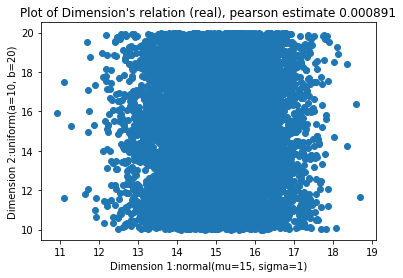

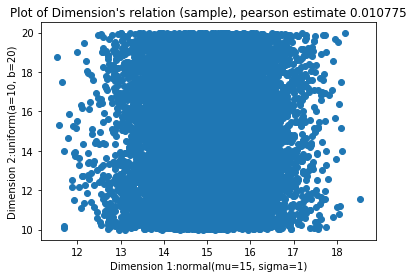

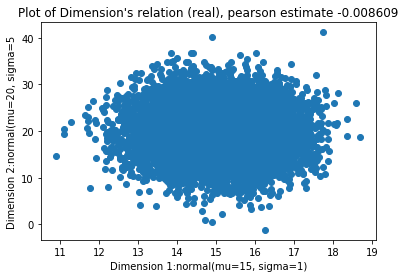

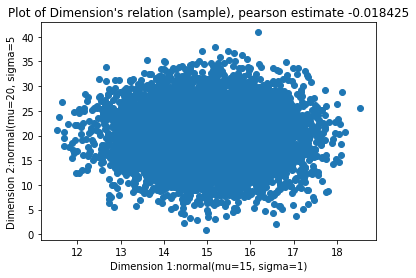

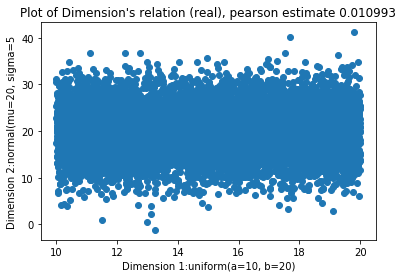

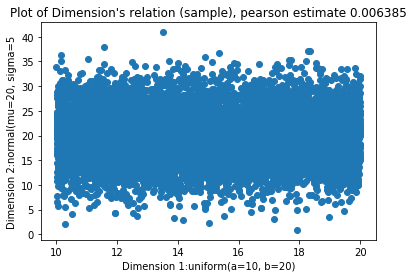

In [218]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

for dim1, text1 in zip([0,1,2],["normal(mu=15, sigma=1)","uniform(a=10, b=20)","normal(mu=20, sigma=5"]):
    for dim2, text2 in zip([0,1,2],["normal(mu=15, sigma=1)","uniform(a=10, b=20)","normal(mu=20, sigma=5"]):
        if dim1 < dim2:
            plt.scatter(M[:,dim1],M[:,dim2])
            plt.title("Plot of Dimension's relation (real), pearson estimate %f" 
                      %(np.corrcoef(M[:,dim1],M[:,dim2])[0,1]))
            plt.xlabel("Dimension 1:"+text1)
            plt.ylabel("Dimension 2:"+text2)
            plt.show()
            
            plt.scatter(sample_data[:,dim1],sample_data[:,dim2])
            plt.title("Plot of Dimension's relation (sample), pearson estimate %f" %
                      (np.corrcoef(sample_data[:,dim1],sample_data[:,dim2])[0,1]))
            plt.xlabel("Dimension 1:"+ text1)
            plt.ylabel("Dimension 2:"+ text2)
            plt.show()

Como puede observar el lector, el coeficiente de relación de pearson varia entre las muestras, esto debido a que la correlación de las muestras normales aleatoriamente generadas tienen una correlación insignificante, por lo que se transmite el error, en las muestras con una correlación más alta, se obtienen correlaciones parecidas.

In [222]:
dim1 = np.random.normal(15,1,10000)
dim2 = np.random.uniform(5,20,10000)
M = np.column_stack((dim1,dim2))

#Llamamos a la clase
Prueba = Norta()
Prueba.set_marginal('normal', mu=15, sigma=1)
Prueba.set_marginal('uniform', a=5, b=20)
Prueba.set_data(M)
sample_data = Prueba.generate_sample(10000)

Normal function successfully added
Uniform function successfully added
Calculated correlataion: [[1. 0.]
 [0. 1.]]


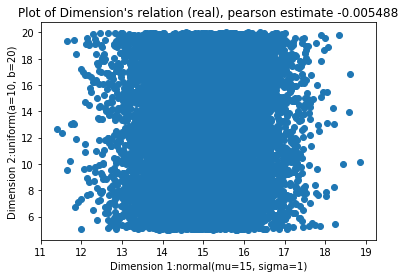

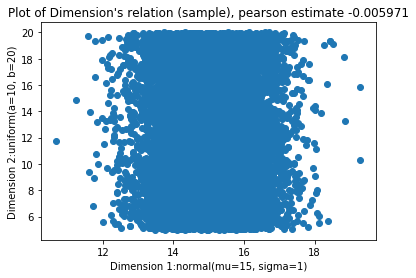

In [223]:
for dim1, text1 in zip([0,1],["normal(mu=15, sigma=1)","uniform(a=10, b=20)"]):
    for dim2, text2 in zip([0,1],["normal(mu=15, sigma=1)","uniform(a=10, b=20)"]):
        if dim1 < dim2:
            plt.scatter(M[:,dim1],M[:,dim2])
            plt.title("Plot of Dimension's relation (real), pearson estimate %f" 
                      %(np.corrcoef(M[:,dim1],M[:,dim2])[0,1]))
            plt.xlabel("Dimension 1:"+text1)
            plt.ylabel("Dimension 2:"+text2)
            plt.show()
            
            plt.scatter(sample_data[:,dim1],sample_data[:,dim2])
            plt.title("Plot of Dimension's relation (sample), pearson estimate %f" %
                      (np.corrcoef(sample_data[:,dim1],sample_data[:,dim2])[0,1]))
            plt.xlabel("Dimension 1:"+ text1)
            plt.ylabel("Dimension 2:"+ text2)
            plt.show()